In [1]:
import Pkg

Pkg.add("Interpolations")
#Pkg.add("Plots")
Pkg.add("PyPlot")
Pkg.add("PyCall")
Pkg.add("OrdinaryDiffEq")
Pkg.add("YAML")
Pkg.add("DelimitedFiles")
Pkg.add("CSV")
Pkg.add("HDF5")
Pkg.add("StructArrays")
Pkg.add("Random")
#Pkg.add("NBInclude")
#Pkg.add("Revise")

using Interpolations, PyCall, OrdinaryDiffEq,
YAML, DelimitedFiles, CSV, HDF5, StructArrays, Random, 
NBInclude, PyPlot#, Revise

ct = pyimport("cantera")

#ENV["PYTHON"] = "/opt/conda/envs/lae2020/bin/python"
#Pkg.build("PyCall")

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/GCresearch/rocketemissions/Project.toml`
No Changes to `~/GCresearch/rocketemissions/Manifest.toml`
  Resolving package versions...
No Changes to `~/GCresearch/rocketemissions/Project.toml`
No Changes to `~/GCresearch/rocketemissions/Manifest.toml`
  Resolving package versions...
No Changes to `~/GCresearch/rocketemissions/Project.toml`
No Changes to `~/GCresearch/rocketemissions/Manifest.toml`
  Resolving package versions...
No Changes to `~/GCresearch/rocketemissions/Project.toml`
No Changes to `~/GCresearch/rocketemissions/Manifest.toml`
  Resolving package versions...
No Changes to `~/GCresearch/rocketemissions/Project.toml`
No Changes to `~/GCresearch/rocketemissions/Manifest.toml`
  Resolving package versions...
No Changes to `~/GCresearch/rocketemissions/Project.toml`
No Changes to `~/GCresearch/rocketemissions/Manifest.toml`
  Resolving package versions...
No Changes to `~/GCr

PyObject <module 'cantera' from '/opt/conda/envs/lae2020/lib/python3.8/site-packages/cantera/__init__.py'>

In [2]:
"Composite type to hold ambient conditions, parameters and initial conditions"
struct AmbientConditions
    "Ambient velocity [m/s]"
    u_a::AbstractFloat
    "Ambient temperature [K]"
    T_a::AbstractFloat
    "Prandtl number"
    Pr::AbstractFloat
    "Lewis number"
    Le::AbstractFloat
    "Specific gas constant of air [J/kg]"
    R::AbstractFloat
    "Ambient pressure [Pa]"
    p::AbstractFloat
    "Initial temperature [K]"
    T0::AbstractFloat
    "Initial velocity [m/s]"
    u0::AbstractFloat
end

"""
    second_order_central(x, i, Δ)
Computes the second order central difference approximation to the second
derivative of the variable x w.r.t. its discretization dimension (e.g. x is
the state, and its entries x[i] are the values for different radial dimensions)
using the step size Δ, at location i.
# Inputs
- `x` State vector
- `i` Index to compute second order difference for 
- 'Δ' The spacing between the vector elements
"""
function second_order_central(x::AbstractVector, i::Integer, Δ::AbstractFloat)
    return ((x[i+1] - 2 * x[i] + x[i-1]) / Δ^2)
end

"""
    construct_rhs(u, T, y, Δψ, Δϕ, ambient; χ=nothing)
Constructs the right-hand-side vector for the system `Ax=b` resulting
from applying the Crank-Nicholson scheme to the governing equations.
# Inputs 
- `u` axial velocities
- `T` temperature
- `y` y-locations of grid points 
- `Δψ` Spacing between grid points in ϕ-ψ space
- `Δϕ` Step size in ϕ-ψ space
- `ambient` Ambient conditions
- `χ` Mixing ratio of passive tracer
"""
function construct_rhs(u::AbstractVector, T::AbstractVector, y::AbstractVector,
    Δψ::AbstractVector, Δϕ::AbstractFloat, ambient::AmbientConditions)

    b = zeros(size(u)[1] + size(T)[1])
    
    ## Boundary conditions                                   
    # Neumann conditions at y=0
    b[1] = 0.0
    b[size(u)[1]+1] = 0.0

    # Dirichlet conditions at y -> infinity 
    b[size(u)[1]] = ambient.u_a
    b[size(u)[1]+size(T)[1]] = ambient.T_a

    # Definition for convenience 
    λ = ambient.u0 / ((ambient.R / ambient.p)^2 * ambient.T0^2)
    Le = ambient.Le

    # Loop through b 
    for i = 2:size(u)[1]-1
        b[i] = u[i] / Δϕ + 0.5 * λ * y[i]^2 * second_order_central(u, i, Δψ[i])
        b[i+size(u)[1]] = (T[i] / Δϕ + 0.5 * λ * y[i]^2
                                       * second_order_central(T, i, Δψ[i]) / ambient.Pr)
    end

    return b
end

"""
    construct_tridiagonal_matrix(n, Δψ, Δϕ, y, ambient)
Constructs the matrix `A` for the system `Ax=b` resulting
from applying the Crank-Nicholson scheme to the governing equations.
# Inputs 
- `n` Number of grid points in radial direction
- `Δψ` Spacing between grid points in ϕ-ψ space
- `Δϕ` Step size in ϕ-ψ space
- `y` y-locations of grid points 
- `ambient` Ambient conditions
"""
function construct_tridiagonal_matrix(n::Integer, Δψ::AbstractVector,
    Δϕ::AbstractFloat, y::AbstractVector, ambient::AmbientConditions;)

    A = zeros((2 * n, 2 * n))

    ## Boundary conditions 
    # Neumann conditions at y=0
    A[1, 1] = (-1 / (Δψ[1]))
    A[1, 2] = 1 / (Δψ[1])
    A[n+1, n+1] = -1 / Δψ[1]
    A[n+1, n+2] = 1 / Δψ[1]

    # Dirichlet conditions at y -> infinity 
    A[n, n] = 1.0
    A[2*n, 2*n] = 1.0

    # Definition for convenience 
    λ = ambient.u0 / ((ambient.R / ambient.p)^2 * ambient.T0^2)

    Pr = ambient.Pr
    Le = ambient.Le

    # Loop through matrix 
    for i = 2:n-1

        # For u 
        A[i, i] = 1 / Δϕ + λ * y[i]^2 / (Δψ[i]^2)
        A[i, i-1] = -λ * y[i]^2 / (2 * Δψ[i]^2)
        A[i, i+1] = -λ * y[i]^2 / (2 * Δψ[i]^2)

        # For T
        j = i + n
        A[j, j] = 1 / Δϕ + λ * y[i]^2 / (Pr * Δψ[i]^2)
        A[j, j-1] = -λ * y[i]^2 / (2 * Pr * Δψ[i]^2)
        A[j, j+1] = -λ * y[i]^2 / (2 * Pr * Δψ[i]^2)
    end

    return A
end

"""
    compute_y(u, T, Δψ, R, p)
Computes y locations corresponding to particular states, based on the 
grid spacing in ϕ-ψ space. 
# Inputs 
- `u` axial velocities
- `T` temperature
- `Δψ` Spacing in ϕ-ψ space
- `R` Specific gas constant for air in J/kg
- `p` Ambient pressure in Pa
"""
function compute_y(u::AbstractVector, T::AbstractVector, Δψ::AbstractVector,
    R::AbstractFloat, p::AbstractFloat)
    
    return (2 * cumsum((R / p) * T ./ u) .* Δψ) .^ 0.5

end

"""
   compute_x(ϵ, Δϕ)
Computes x locations of the grid based on turbulent mixing coefficient ϵ
and step sizes Δϕ
# Inputs 
- `ϵ` Values of the turbulent mixing coefficient
- `Δϕ` Step sizes
"""
function compute_x(ϵ::AbstractVector, Δϕ::AbstractVector)
    x = zeros(size(ϵ))
    x[2:end] = cumsum(Δϕ[1:end-1] ./ ϵ[1:end-1])
    return x
end

"""
    compute_ψ(u, T, y, p, R)
Computes the transformed coordinate ψ based on the state and y locations.
# Inputs
- `u` axial velocities
- `T` temperature
- `y` y-locations of grid points 
- `R` Specific gas constant for air in J/kg
- `p` Ambient pressure in Pa
"""
function compute_ψ(u::AbstractVector, T::AbstractVector, y::AbstractVector,
    p::AbstractFloat, R::AbstractFloat)
    return cumsum(p ./ (R * T) .* (y[2:end] .- y[1:end-1]) .* u)
end

"""
    get_ϵ(κ, u, y)
Computes the turbulent mixng coefficient based on current velocity profile.
# Inputs
- `κ` Empirical parameter
- `u` axial velocities
- `y` y-locations of grid points 
"""
function get_ϵ(κ::AbstractFloat, u::AbstractVector, y::AbstractVector)
    # First find the half-width 
    fractional_change = (u .- u[end]) ./ (u[1] - u[end])
    idx = argmin(abs.(fractional_change .- 0.5))
    half_width = y[idx]
    return κ * (u[1] - u[end]) * half_width
end

"""
    solve_exhaust_flow(u_init, T_init, ambient, n, Δϕ, Δψ; χ_init=nothing)
Solves for the velocity, temperature and optionally passive tracer profiles
within an aircraft engine exhaust jet.
# Inputs
- `u_init` Initial velocity profile
- `T_init` Initial temperature profile
- `ambient` AmbientConditions struct
- `n` Number of grid points in the radial direction
- `Δϕ` Grid spacing in ϕ-ψ space.
- `Δψ` Grid spacing in ϕ-ψ space.
- `χ_init` Initial passive tracer profile.
"""
function solve_exhaust_flow(u_init::AbstractVector, T_init::AbstractVector,
    ambient::AmbientConditions, n::Integer, Δϕ::AbstractVector,
    Δψ::AbstractVector)

    
    u_mem = zeros((size(u_init)[1], n))
    T_mem = zeros((size(u_init)[1], n))
    y_mem = zeros((size(u_init)[1], n))
    u_mem[:, 1] = u_init
    T_mem[:, 1] = T_init
    ϵ = zeros(n)

    @inbounds for i = 1:n-1
        
        y_mem[:, i] = compute_y(@view(u_mem[:, i]), @view(T_mem[:, i]), Δψ, ambient.R, ambient.p)


        A = construct_tridiagonal_matrix(size(u_init)[1], Δψ, Δϕ[i], @view(y_mem[:, i]), ambient)
        b = construct_rhs(@view(u_mem[:, i]), @view(T_mem[:, i]), @view(y_mem[:, i]), Δψ, Δϕ[i], ambient)
        sol = A \ b
        u_mem[:, i+1] = sol[1:size(u_init)[1]]
        T_mem[:, i+1] = sol[size(u_init)[1]+1:end]
        
        ϵ[i] = get_ϵ(0.02, @view(u_mem[:, i]), @view(y_mem[:, i]))
    end

    x = compute_x(ϵ, Δϕ)
    
    return x, y_mem, u_mem, T_mem, ϵ
end

"""
    regrid_solution(x, y, u, T, χ, y_spacing)
Maps back solution from a grid in ϕ-ψ space to a grid in x-y space.
# Inputs
- `x` x coordinates corresponding to the grid
- `y` y coordinates corresponding to the grid
- `u` Velocity values of solution
- `T` Temperature values of solution
- `y_spacing` Desired spacing in `y` direction for output grid
"""
function regrid_solution(x::AbstractVector, y::AbstractMatrix, u::AbstractMatrix,
    T::AbstractMatrix, χ::AbstractMatrix, y_spacing::AbstractFloat)

    yy = 0:y_spacing:maximum(y)

    u_gridded = zeros((size(yy)[1], size(x)[1]))
    T_gridded = zeros((size(yy)[1], size(x)[1]))
    χ_gridded = zeros((size(yy)[1]), size(x)[1])

    for j = 1:size(x)[1]
        u_interp_extrap = LinearInterpolation(y[:, j], u[:, j], extrapolation_bc=Line())
        u_gridded[:, j] = u_interp_extrap(yy)
        T_interp_extrap = LinearInterpolation(y[:, j], T[:, j], extrapolation_bc=Line())
        T_gridded[:, j] = T_interp_extrap(yy)
        χ_interp_extrap = LinearInterpolation(y[:, j], χ[:, j], extrapolation_bc=Line())
        χ_gridded[:, j] = χ_interp_extrap(yy)
    end

    return x, yy, u_gridded, T_gridded, χ_gridded
end

function show_profiles(x, y, var, cols)
    labels = ["x = $xx m" for xx in x[cols]]
    plot(var[:, cols], y[:, cols], dpi=300, label=permutedims(labels))
end

"""
    plot_heatmap(x, y, var, xlabel, ylabel, clabel, colormap)
Plots gridded solution. 
# Inputs
- `x` x location of grid points
- `y` y location of grid points
- `var` Solution variable values at grid points
- `xlabel` Label for horizontal axis
- `ylabel` Label for vertical axis
- `clabel` Label for colormap
- `colormap` Colormap to use (e.g. :viridis)
"""
function plot_heatmap(x, y, var, xlabel, ylabel, clabel, colormap, x_max)
    # This is kind of hard-coded, to avoid any issues with the first entry of
    # `x` which typically is zero. 

    y_plot = 20.0 .* range(0, stop=1, length=size(y)[1])
    y_len = length(y)
    u = 0
    x_lim = 0

    for g in 1:length(x)
        if x[g] >= x_max && u == 0#desired xlim
            x_lim = g
            u = 1
        end
    end

    heatmap((x[2:x_lim]), y, clim=(0, Inf),
        var[1:y_len, 2:x_lim], colorbar_title=clabel, size=(700, 500), dpi=300, c=colormap)
    xlabel!(xlabel)
    ylabel!(ylabel)
    #xticks!([-2, -1, 0, 1, 2, 3], ["0.1", "1", "10", "100",])
end

struct AmbientConditionsχ
    "Ambient velocity [m/s]"
    u_a::AbstractFloat
    "Ambient temperature [K]"
    T_a::AbstractFloat
    "Ambient passive tracer mixing ratio"
    χ_a::Array
    "Prandtl number"
    Pr::AbstractFloat
    "Lewis number"
    Le::AbstractFloat
    "Specific gas constant of air [J/kg]"
    R::AbstractFloat
    "Ambient pressure [Pa]"
    p::AbstractFloat
    "Initial temperature [K]"
    T0::AbstractFloat
    "Initial velocity"
    u0::AbstractFloat
    "Initial passive tracer mixing ratio"
    χ0::Array
end


function solve_reaction(χ_h0, T, Δϕ, ϵ, u, gas, j, χ_1, s, n_species, gas_prop)
    #temp drops but should have ambient amounts instead of initial amounts
    P = 101325 #Pa
    ω = zeros(size(χ_h0))

    reactor = ct.IdealGasConstPressureReactor(gas)

    #FOR NO REACTIONS
    gas.set_multiplier(0)

    states = ct.SolutionArray(gas)

    for i = 1:length(χ_h0[:, 1]) #index through all "y"s

        try
            gas.TPX = T[i], P, χ_h0[i, :] #GO THROUGH TO SEE IF SETTING AND UPDATING GAS CORRECTLY
        catch
            println(i)
            print(gas.report())
        end

        reactor.syncState()
        reactorNet = ct.ReactorNet([reactor])
        t_final = Δϕ / (u[i] * abs(ϵ))
        t = 0

        reactorNet.advance(t_final, apply_limit=false)

        states.append(reactor.thermo.state)

        χ_1[i, :] = 10^6 .* reactor.thermo.X #mole fraction to ppm state.X[len,:] 10^9 #kmol/m^3s, assume 1 m^3, to ppm #rates for specific y (i) and all species UNITS

    end

    return χ_1, states #for all y and all species [s,n_species]

end

function construct_tridiagonal_matrix_χ(n::Integer, Δψ::AbstractVector,
    Δϕ::AbstractFloat, y::AbstractVector, ambient::AmbientConditionsχ)

    A = zeros((n, n))

    ## Boundary conditions 
    # Neumann conditions at y=0 #change
    A[1, 1] = -1 / (Δψ[1])
    A[1, 2] = 1 / (Δψ[1])

    # Dirichlet conditions at y -> infinity #change
    A[n, n] = 1.0

    # Definition for convenience
    Pr = ambient.Pr
    Le = ambient.Le
    λ = (Le / Pr) * ((ambient.u0 * ambient.p^2) / ((ambient.R * ambient.T0)^2))

    # Loop through matrix 
    for j = 2:n-1
        # For χ
        A[j, j] = 1 / Δϕ + λ * y[j]^2 * 2 / (Δψ[j]^2)
        A[j, j-1] = -λ * y[j]^2 / (Δψ[j]^2)
        A[j, j+1] = -λ * y[j]^2 / (Δψ[j]^2)
    end
    return A
end

function construct_rhs_χ(u, T, y, Δψ, Δϕ, ambient::AmbientConditionsχ, χ, j)

    b = zeros(size(χ)[1])

    ## Boundary conditions
    # Neumann conditions at y=0 #change
    b[1] = 0.0

    # Dirichlet conditions at y -> infinity #change
    b[size(χ)[1]] = ambient.χ_a[j]

    # Definition for convenience 
    Pr = ambient.Pr
    Le = ambient.Le
    λ = (Le / Pr) * ((ambient.u0 * ambient.p^2) / ((ambient.R * ambient.T0)^2))

    # Loop through b
    for i = 2:size(χ)[1]-1
        b[i] = χ[i] / Δϕ + λ * y[i]^2 * second_order_central(χ, i, Δψ[i])
        #took out 0.5 factor on lambda (not 100% sure why was there) ^^^
    end

    return b
end

function solve_exhaust_flow_χ(u_mem, T_mem, ambient::AmbientConditionsχ, n::Integer,
    Δϕ, Δψ::AbstractVector, χ_init, i, j)

    y_mem = zeros(size(u_mem))

    χ_mem = χ_init

    y_mem = compute_y(u_mem, T_mem, Δψ, ambient.R, ambient.p)

    A = construct_tridiagonal_matrix_χ(size(u_mem)[1], Δψ, Δϕ, y_mem, ambient)
    
    b = construct_rhs_χ(u_mem, T_mem, y_mem, Δψ, Δϕ, ambient, χ_mem, j)

    sol = A \ b

    χ_mem = sol

    return χ_mem
end

struct gas_type
    gas
end

In [3]:
n_species = 53
upper = 20000 #[m]
lower = 16000 #[m]
space = convert(Int, (upper - lower) / 2000 + 1) #250
h = Int.(LinRange(16000, 20000, space))
g = 1

n = 100 #90 #n steps in x dir
s = 50 #80 #s steps in y direction
neg_sum = zeros(s)
pos_sum = zeros(s)
T_save = zeros(length(h), s, n)
u_save = zeros(length(h), s, n)
χ_save = zeros(length(h), s, n, n_species)
x_save = zeros(n)
y_save = zeros(s)
gas_g = StructArray{gas_type}(undef,s,n,length(h))
gas_g .= [gas_type(0)]

for m = 1:length(h)
    h_string = string(h[m])

    ### IMPORT SHOCK EXIT CONDITIONS ###

    u0 = HDF5.h5read("/home/chinahg/GCresearch/rocketemissions/plot_data.h5", h_string * "m/u")#initial plume velocity
    u0 = convert(AbstractFloat, u0[2])

    T0 = HDF5.h5read("/home/chinahg/GCresearch/rocketemissions/plot_data.h5", h_string * "m/T") #initial plume temperature
    T0 = convert(AbstractFloat, T0[2])

    χ0 = 4.e4 #tracer species
    p_all = HDF5.h5read("/home/chinahg/GCresearch/rocketemissions/plot_data.h5", h_string * "m/P")
    p = convert(AbstractFloat, p_all[2])

    u_a = 1.11849E-19 * big(h[m])^5 - 1.14814E-14 * big(h[m])^4 + 4.22542E-10 * big(h[m])^3 - 6.92322E-06 * big(h[m])^2 + 6.58761E-02 * big(h[m]) + 5.37920E+01

    #curve fit #a = ambient vel [m/s] (speed of rocket) 
    T_a = HDF5.h5read("/home/chinahg/GCresearch/rocketemissions/plot_data.h5", h_string * "m/T_a")
    χ_a = 70.0 #passive tracer mixing ratio [ppm], just for vincent calculations

    ### CALCULATE VELOCITY AND TEMPERATURE FIELDS (NO CHEMISTRY) ###

    Δϕ = 0.5 * ones(n) #step size in phi
    for i = 2:n
        Δϕ[i] = 2 * Δϕ[i-1] #enlarge with each step by 1.1
    end

    Δψ = 0.5 * ones(s) #s vertical grid points
    for i = 2:s
        Δψ[i] = 1.1 * Δψ[i-1] #enlarge with each step by 1.1
    end

    Pr = 1.0 #prandtl number
    Le = 1.0 #lewis number
    u_init = u0 .* ones(s)
    T_init = T0 .* ones(s)
    χ_init = χ0 .* ones(s)

    R = 287.0
    y_init = compute_y(u_init, T_init, Δψ, R, p)

    #Geometry of plume
    radius = 1.147
    u_init[y_init.>radius] .= convert(AbstractFloat, u_a)
    T_init[y_init.>radius] .= convert(AbstractFloat, T_a)
    χ_init[y_init.>radius] .= convert(AbstractFloat, χ_a)

    ambient = AmbientConditions(u_a, T_a, 1.0, 1.0, R, p, T0, u0)

    #Solve for T and u at all steps: NO CHEMISTRY
    x, y, u, T, ϵ = solve_exhaust_flow(u_init, T_init, ambient, n, Δϕ, Δψ)
    x_save = x
    y_save = y
    T_save[m, :, :] = T
    u_save[m, :, :] = u

    ### CHEMISTRY STARTS HERE

    #SET INITIAL PLUME CONDITIONS
    #import concentration data from upstream combustion
    χ0_full = HDF5.h5read("/home/chinahg/GCresearch/rocketemissions/plot_data.h5", h_string * "m/X")
    χ0 = zeros(n_species)
    #for d = 1: length(χ0_full[:,2])-1
    #    χ0[d] = χ0_full[d,2]

    #end
    χ0[49] = 1000000 #FOR MASS CONS TEST, DELETE LATER 49

    #ppm must sum to a million

    #Redefine species initial conditions for multiple species
    χ_a = zeros(n_species)

    χ_a[48] = 780790 #ppm N2
    χ_a[4] = 209445 #ppm O2
    χ_a[49] = 0 #ppm Ar #CHANGE BACK AFTER DEBUG TO 9339
    χ_a[16] = 9765 #ppm CO2 426

    χ_init = zeros(s, n_species)

    ### COMPUTE MOLE FRACTIONS IN PLUME ###

    i = y_init .>= radius
    for j = 1:length(i) 
        if i[j] == 0 #if y position is less than the initial plume radius, assign plume conditions
            for k = 1:n_species
                χ_init[j, k] = χ0[k] #initial plume conditions
            end
        else #if y position is greater than the initial plume radius, assign ambient conditions
            χ_init[j, 48] = χ_a[48]
            χ_init[j, 4] = χ_a[4]
            χ_init[j, 49] = χ_a[49]
            χ_init[j, 16] = χ_a[16]
        end
    end

    # Save ambient conditions to a struct to call later easily
    ambient = AmbientConditionsχ(u_a, T_a, χ_a, 1.0, 1.0, R, p, T0, u0, χ0)

    # Create 3D array to save concentrations at each y,x location
    χ = zeros(length(u[:, 1]), length(u[1, :]), n_species) #[y,x,species]

    χ[:, 1, :] = χ_init # at x=1 assign concentrations for all species at all y

    # Initialize arrays for Strang-Splitting
    χ_h0 = zeros(size(χ_init))
    χ_1 = zeros(size(χ_init))
    
    # Create gas object to store Reactor output gas object state
    gas = ct.Solution("gri30.yaml")

    # Create a dummy reactor to ????
    dummy_reactor = ct.IdealGasReactor(gas)

    for i = 1:n-1 #x
        
        for j = 1:n_species #species
            #calculate f0 at half step 0.5*Δϕ (x)
            χ_h0[:, j] = solve_exhaust_flow_χ(u[:, i], T[:, i], ambient, n, 0.5 * Δϕ[i], Δψ, χ[:, i, j], i, j)
            # concentration of species j at x = i and y = all
        end

        save_tuple = solve_reaction(χ_h0, T[:, i], Δϕ[i], ϵ[i], u[:, i], gas, i, χ_1, s, n_species, @view gas_g[:,i,m])
        gas_g.gas[:,i,m] .= save_tuple[2]
        χ_1 = save_tuple[1]

        for j = 1:n_species-1 #species
            #calculate f0 at full step Δϕ
            χ[:, i+1, j] = solve_exhaust_flow_χ(u[:, i], T[:, i], ambient, n, 0.5 * Δϕ[i], Δψ, χ_1[:, j], i, j)
        end

        i = i + 1
    end
    χ_save[m, :, :, :] = χ

    print(m, " of ", length(h), " altitudes done!\n")
end
println("done computing! 💕")

1 of 3 altitudes done!
2 of 3 altitudes done!
3 of 3 altitudes done!
done computing! 💕


┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
└ @ Interpolations /home/chinahg/.julia/packages/Interpolations/L7A07/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
└ @ Interpolations /home/chinahg/.julia/packages/Interpolations/L7A07/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were ded

plotted 1 altitude!


┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
└ @ Interpolations /home/chinahg/.julia/packages/Interpolations/L7A07/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
└ @ Interpolations /home/chinahg/.julia/packages/Interpolations/L7A07/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were ded

plotted 8 altitude!


┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
└ @ Interpolations /home/chinahg/.julia/packages/Interpolations/L7A07/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
└ @ Interpolations /home/chinahg/.julia/packages/Interpolations/L7A07/src/gridded/gridded.jl:77
┌ Warning: Duplicated knots were ded

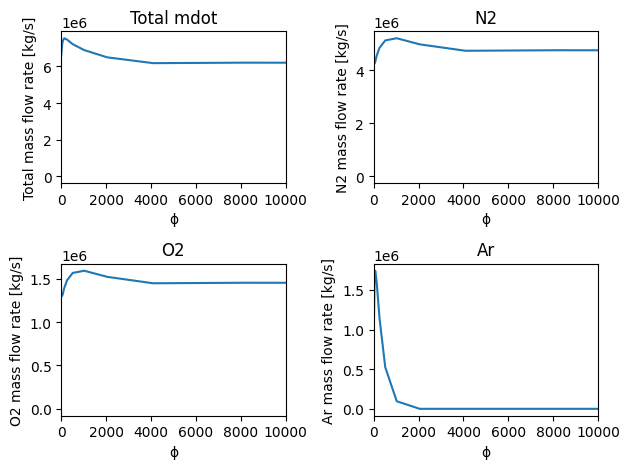

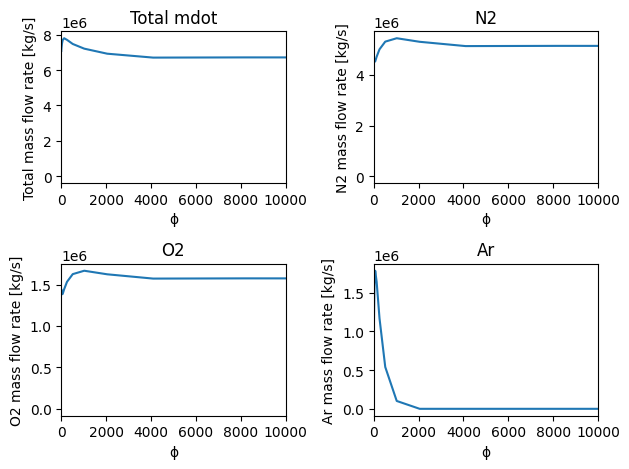

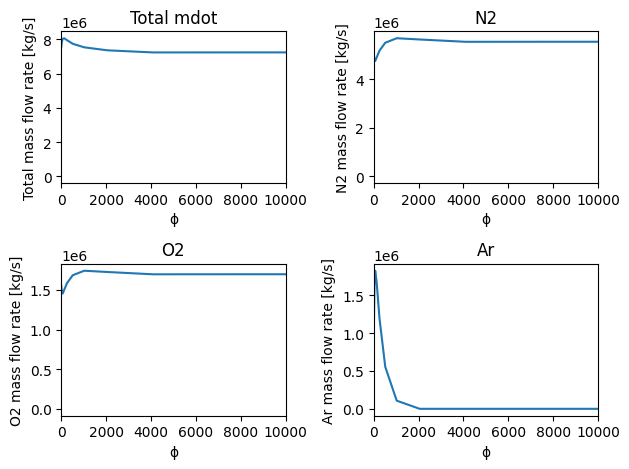

plotted 0 altitude!

 done plotting!

In [21]:
# Define altitude range to plot over
h = Int.(LinRange(16000, 20000, space)) #make an array and put in loop for all alts
h_string_arr = string(h)

for m = 1:length(h) #For all specified altitudes

    # Initialize arrays to save results
    T = T_save[m, :, :] #temperature
    u = u_save[m, :, :] #velocity
    χ = χ_save[m, :, :, :] #concentrations
    x = x_save
    y = y_save
    h_string = string(h[m])
    P_atm = 101325 #placeholder, need altitude dependent
    R = 8.314 #placeholder

    #REGRID SOLUTION
    #xx, yy, u_g, T_g, χ_gH2O =  regrid_solution(x, y, u, T, χ[:,:,6], 0.01);
    #xx, yy, u_g, T_g, χ_gH2 =  regrid_solution(x, y, u, T, χ[:,:,1], 0.01);
    xx, yy, u_g, T_g, χ_gO2 =  regrid_solution(x, y, u, T, χ[:,:,4], 0.01)
    xx, yy, u_g, T_g, χ_gN2 =  regrid_solution(x, y, u, T, χ[:,:,48], 0.01)
    xx, yy, u_g, T_g, χ_gNO2 = regrid_solution(x, y, u, T, χ[:, :, 37], 0.01)
    xx, yy, u_g, T_g, χ_gN2O = regrid_solution(x, y, u, T, χ[:, :, 38], 0.01)
    xx, yy, u_g, T_g, χ_gNO = regrid_solution(x, y, u, T, χ[:, :, 36], 0.01)
    xx, yy, u_g, T_g, χ_gAr = regrid_solution(x, y, u, T, χ[:, :, 49], 0.01)

    #PLOT 2D MAPS AND SAVE
    x_max = 20 #[m]
    #plot_H2O = plot_heatmap(xx, yy, χ_gH2O, "Axial distance, m", "Radial distance, m","Concentration", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/"*h_string*"m/X_H2O.png")
    #plot_NO2 = plot_heatmap(xx, yy, χ_gNO2, "Axial distance, m", "Radial distance, m","Concentration", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/"*h_string*"m/X_NO2.png")
    #plot_N2O = plot_heatmap(xx, yy, χ_gN2O, "Axial distance, m", "Radial distance, m","Concentration", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/"*h_string*"m/X_N2O.png")
    #plot_NO = plot_heatmap(xx, yy, χ_gNO, "Axial distance, m", "Radial distance, m","Concentration", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/"*h_string*"m/X_NO.png")
    #plot_Ar = plot_heatmap(xx, yy, χ_gAr, "Axial distance, m", "Radial distance, m", "Concentration", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/"*h_string*"m/X_Ar.png")
    #plot_N2 = plot_heatmap(xx, yy, χ_gN2, "Axial distance, m", "Radial distance, m", "Concentration", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/"*h_string*"m/X_N2.png")
    #plot_O2 = plot_heatmap(xx, yy, χ_gO2, "Axial distance, m", "Radial distance, m", "Concentration", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/"*h_string*"m/X_O2.png")

    #CALCULATE NO EI FOR ALTITUDE
    # Sum of all NOx species as a function of x
    sumNO = zeros(n)
    sumNO2 = zeros(n)
    sumN2O = zeros(n)
    Xarea = zero(u_g)
    EI_Ar = zero(u_g)
    i = 1
    j = 1

    x_lim = length(xx)
    y_lim = length(yy)

    MW_Ar = 39.95 #[kg/mol]
    mdot_fuel = 67.35 #[kg/s]
    rho_tot = zeros(s,n)
    MFar = zeros(s,n)
    MFn2 = zeros(s,n)
    MFo2 = zeros(s,n)

    mdot_Ar_sum = zeros(n)
    mdot_N2_sum = zeros(n)
    mdot_O2_sum = zeros(n)
    mdot_Ar = zeros(s,n)
    mdot_N2 = zeros(s,n)
    mdot_O2 = zeros(s,n)
    mdot_tot = zeros(n)

    Δψ = 0.5 * ones(s) #s vertical grid points
    for i = 2:s
        Δψ[i] = 1.1 * Δψ[i-1] #enlarge with each step by 1.1
    end

    Δϕ = 0.5 * ones(n) #step size in phi
    for i = 2:n
        Δϕ[i] = 2 * Δϕ[i-1] #enlarge with each step by 1.1
    end

    for i = 1:n-1, j = 1:s-1
        rho_tot[j,i] = gas_g.gas[j,i,m].density_mass[1] #[kg/m^3] #need to convert to xx yy coordinates
        MFar[j,i] = gas_g.gas[j,i,m]("Ar").Y[1] #[kg/kg tot]
        MFn2[j,i] = gas_g.gas[j,i,m]("N2").Y[1] #[kg/kg tot]
        MFo2[j,i] = gas_g.gas[j,i,m]("O2").Y[1] #[kg/kg tot]
        Xarea[j,i] = 3.1415*(Δψ[j+1]^2 - Δψ[j]^2)

        mdot_Ar[j,i] = Xarea[j,i]*MFar[j,i]*rho_tot[j,i]*u[j,i]
        mdot_N2[j,i] = Xarea[j,i]*MFn2[j,i]*rho_tot[j,i]*u[j,i]
        mdot_O2[j,i] = Xarea[j,i]*MFo2[j,i]*rho_tot[j,i]*u[j,i]

        mdot_O2_sum[i] += mdot_O2[j,i]
        mdot_N2_sum[i] += mdot_N2[j,i]
        mdot_Ar_sum[i] += mdot_Ar[j,i]
        mdot_tot[i] += mdot_Ar[j,i] + mdot_N2[j,i] + mdot_O2[j,i]
    end

    xx, yy, u_g, T_g, rho_tot_g = regrid_solution(x, y, u, T, rho_tot, 0.01)
    xx, yy, u_g, T_g, MFar_g = regrid_solution(x, y, u, T, MFar, 0.01)
    xx, yy, u_g, T_g, MFn2_g = regrid_solution(x, y, u, T, MFn2, 0.01)
    xx, yy, u_g, T_g, MFo2_g = regrid_solution(x, y, u, T, MFo2, 0.01)
    xx, yy, u_g, T_g, mdot_Ar_g = regrid_solution(x, y, u, T, mdot_Ar, 0.01)
    xx, yy, u_g, T_g, mdot_N2_g = regrid_solution(x, y, u, T, mdot_N2, 0.01)
    xx, yy, u_g, T_g, mdot_O2_g = regrid_solution(x, y, u, T, mdot_O2, 0.01)

    flux_N2 = zeros(x_lim)
    flux_Ar = zeros(x_lim)
    flux_O2 = zeros(x_lim)

    for i = 1:x_lim-1, j = 1:y_lim-1
        flux_N2[i] += mdot_N2_g[j,i]
        flux_Ar[i] += mdot_Ar_g[j,i]
        flux_O2[i] += mdot_O2_g[j,i]
    end
    #print(mdot_Ar_g[:,1])
    #itp = interpolate((xx,), flux_Ar, Gridded(Linear()))
    #
    #plot(xx, itp)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/flux_Ar.png")

    ϕ = cumsum(Δϕ)
    max =10000
    fig,axs = plt.subplots(2,2)
    axs[1,1].plot(ϕ, mdot_tot)
    axs[1,1].set_xlabel("ϕ")
    axs[1,1].set_ylabel("Total mass flow rate [kg/s]")
    axs[1,1].set_title("Total mdot")
    axs[1,1].set_xlim(0,max)

    axs[1,2].plot(ϕ, mdot_N2_sum)
    axs[1,2].set_xlabel("ϕ")
    axs[1,2].set_ylabel("N2 mass flow rate [kg/s]")
    axs[1,2].set_title("N2")
    axs[1,2].set_xlim(0,max)

    axs[2,1].plot(ϕ, mdot_O2_sum)
    axs[2,1].set_xlabel("ϕ")
    axs[2,1].set_ylabel("O2 mass flow rate [kg/s]")
    axs[2,1].set_title("O2")
    axs[2,1].set_xlim(0,max)

    axs[2,2].plot(ϕ, mdot_Ar_sum)
    axs[2,2].set_xlabel("ϕ")
    axs[2,2].set_ylabel("Ar mass flow rate [kg/s]")
    axs[2,2].set_title("Ar")
    axs[2,2].set_xlim(0,max)

    fig.tight_layout()
    savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/mdot_tot.png")

    #plot(xx[1:13], mdot_Ar_g[1,1:13], xlabel = "Axial Distance [m]", ylabel = "mdot Ar in x dir at y = 0")
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/mdot_Ar_y0.png")
    #
    #plot(xx[1:13], flux_N2[1:13])
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/flux_N2.png")
#
    #plot(xx[1:13], flux_O2[1:13])
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/flux_O2.png")
#
    #EI_Ar = Xarea.*MFar_g.*rho_tot_g.*u_g./mdot_fuel
    #
    #plot_heatmap(xx, yy, mdot_Ar_g, "Axial distance, phi", "Radial distance, psi", "mdot Ar", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/mdot_Ar.png")
#
    #plot_heatmap(xx, yy, u_g, "Axial distance, m", "Radial distance, m", "vel", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/u_g.png")
#
    #plot_heatmap(xx, yy, EI_Ar, "Axial distance, m", "Radial distance, m", "EI Ar", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/EI_Ar.png")
#
    #plot_heatmap(xx, yy, mdot_N2_g, "Axial distance", "Radial distance", "mdot N2", :magma, x_max)
    #savefig("/home/chinahg/GCresearch/rocketemissions/rockettests/" * h_string * "m/mdot_N2.png")

    print("plotted ", h_string[m], " altitude!\n")
end

print("\n done plotting!")